# Data Preparation for the Models

In [16]:
import pandas as pd
import numpy as np
import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.tree import export_graphviz
from sklearn.svm import SVC
from pygam import LogisticGAM
from sklearn.metrics import matthews_corrcoef
from dtreeplt import dtreeplt
from sklearn.tree import DecisionTreeClassifier
import graphviz
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb
import matplotlib.pyplot as plt

## Data Filtering and Preprocessing

We aim at predicting "is_recid". Some features in the dataset must be droped in order to remove features that might be directly linked to the target value, such as "is_violent_recid"

In [2]:
df = utils.read_data_files()
df = df.drop(df[df.is_recid == -1].index)

In [3]:
df.head()

,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,...,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,...,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0
5,6.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,...,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0


In [5]:
df.columns

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'priors_count.1', 'event'],
      dtype='object')

In [6]:
FEATURES = ['sex', 'age', 'age_cat', 'race',
            'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
            'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
            'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 
            'score_text', 'screening_date',
            'v_decile_score', 'v_score_text',
            'event']

TARGET = ['is_recid']

In [7]:
# Label encode categorical columns
df_encoded = df[FEATURES + TARGET].copy()
label_encoders = {}

for column in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    label_encoders[column] = le  # Store the label encoder for each column

# Now all columns should be numeric
X = df_encoded.drop('is_recid', axis=1)
y = df_encoded['is_recid']

In [8]:
# Handle missing values if any
X.fillna(X.mean(), inplace=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Black-Box Models

### Random Forest SK Learn

In [9]:
# Create and fit the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the model's performance
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

### CatBoost Classifier

In [10]:
# CatBoost Classifier
cat_model = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=8, loss_function='Logloss')
cat_model.fit(X_train, y_train, verbose=False)
cat_predictions = cat_model.predict(X_test)
cat_accuracy = accuracy_score(y_test, cat_predictions)
cat_roc_auc = roc_auc_score(y_test, cat_model.predict_proba(X_test)[:, 1])

In [11]:
# LightGBM Classifier
lgb_model = lgb.LGBMClassifier(num_iterations=200, learning_rate=0.1, max_depth=8, objective='binary', metric='binary_logloss')
lgb_model.fit(X_train, y_train, verbose=False)
lgb_predictions = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_predictions)
lgb_roc_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1])

/Users/madhuranirale/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [12]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=8, objective='binary:logistic')
xgb_model.fit(X_train, y_train, verbose=False)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

### Neural Networks

In [13]:
# Create a simple neural network model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model's performance
nn_loss, nn_accuracy = model.evaluate(X_test, y_test)

# Predictions from the neural network
nn_predictions = (model.predict(X_test) > 0.5).astype(int)

# You can also calculate ROC AUC if you have binary classification
nn_roc_auc = roc_auc_score(y_test, model.predict(X_test))



Epoch 1/15


2023-11-09 17:50:10.993217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


438/438 [==============================] - 1s 1ms/step - loss: 12.7197 - accuracy: 0.5289 - val_loss: 5.0391 - val_accuracy: 0.5249
Epoch 2/15
438/438 [==============================] - 0s 1ms/step - loss: 4.9510 - accuracy: 0.5459 - val_loss: 5.2502 - val_accuracy: 0.5457
Epoch 3/15
438/438 [==============================] - 0s 1ms/step - loss: 3.2406 - accuracy: 0.5675 - val_loss: 3.7375 - val_accuracy: 0.5423
Epoch 4/15
438/438 [==============================] - 0s 1ms/step - loss: 2.2654 - accuracy: 0.5845 - val_loss: 1.3419 - val_accuracy: 0.6054
Epoch 5/15
438/438 [==============================] - 0s 1ms/step - loss: 2.3735 - accuracy: 0.5766 - val_loss: 1.0570 - val_accuracy: 0.6097
Epoch 6/15
438/438 [==============================] - 0s 1ms/step - loss: 1.5647 - accuracy: 0.5860 - val_loss: 1.0133 - val_accuracy: 0.6277
Epoch 7/15
438/438 [==============================] - 0s 1ms/step - loss: 1.4282 - accuracy: 0.5743 - val_loss: 1.8128 - val_accuracy: 0.5343
Epoch 8/15
438/4

In [14]:
# Print the performance indicators for each model
print(f"Random forest accuracy: {rf_accuracy}, ROC AUC: {rf_roc_auc}")
print(f"CatBoost Accuracy: {cat_accuracy}, ROC AUC: {cat_roc_auc}")
print(f"LightGBM Accuracy: {lgb_accuracy}, ROC AUC: {lgb_roc_auc}")
print(f"XGBoost Accuracy: {xgb_accuracy}, ROC AUC: {xgb_roc_auc}")
print(f"NN Accuracy: {nn_accuracy}, ROC AUC: {nn_roc_auc}")

Random forest accuracy: 0.9191428571428572, ROC AUC: 0.9689803367556039
CatBoost Accuracy: 0.8174285714285714, ROC AUC: 0.8913686119939779
LightGBM Accuracy: 0.828, ROC AUC: 0.8985067643860821
XGBoost Accuracy: 0.8717142857142857, ROC AUC: 0.931780787366176
NN Accuracy: 0.5591428279876709, ROC AUC: 0.6811327406218635


# Surrogate Models

Surrogate Model - DT Accuracy: 0.6917142857142857
Surrogate Model - DT ROC AUC Score: 0.6922570257611242


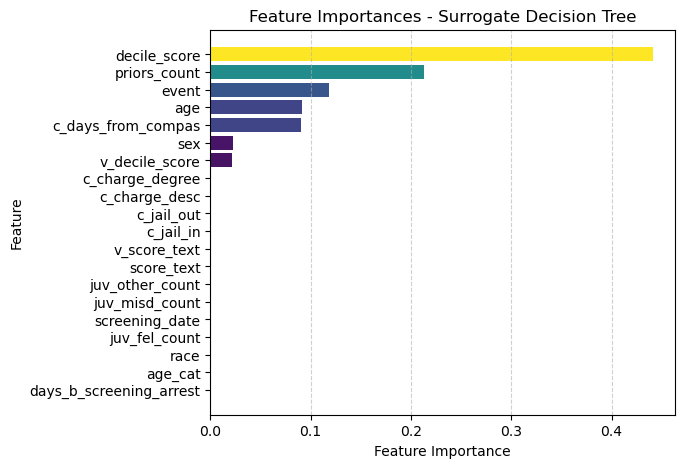

In [24]:
# Step 1: Get predictions of the black box model (CatBoost)
cat_predictions_train = cat_model.predict(X_train)

# Step 2: Select an interpretable model type (Decision Tree)
surrogate_model = DecisionTreeClassifier(max_depth=4)
surrogate_model.fit(X_train, cat_predictions_train)
surrogate_predictions_test = surrogate_model.predict(X_test)

# Evaluate surrogate model performance (you can use different metrics based on your task)
surrogate_accuracy = accuracy_score(y_test,surrogate_predictions_test)
surrogate_auc =  roc_auc_score(y_test,surrogate_predictions_test)

print("Surrogate Model - DT Accuracy:", surrogate_accuracy)
print("Surrogate Model - DT ROC AUC Score:", surrogate_auc)

# Step 5: Interpret the surrogate model (you can visualize the tree structure or feature importances)
# visualize the tree structure


dot_data = export_graphviz(surrogate_model, out_file=None, feature_names=X_train.columns, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("surrogate_DF_tree", format="png", cleanup=True)

# plot feature importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns
feature_importances['importance'] = surrogate_model.feature_importances_

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

# Plot feature importances with color and style adjustments
plt.figure(figsize=(6, 5))
bar_colors = plt.cm.viridis(feature_importances['importance'] / feature_importances['importance'].max())  # Color based on importance

plt.barh(feature_importances['feature'], feature_importances['importance'], color=bar_colors)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - Surrogate Decision Tree')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


# White-Box Models

### Logistic Regression

In [25]:
# Logistic Regression
log_model = LogisticRegression(max_iter=10_000)
log_model.fit(X_train, y_train)
log_predictions = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, log_predictions)
log_roc_auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])

### Generalized Additive Models (GAM)

In [26]:
# Generalized Additive Model (GAM)
gam_model = LogisticGAM().fit(X_train, y_train)
gam_predictions = gam_model.predict(X_test)
gam_accuracy = accuracy_score(y_test, gam_predictions.round())
gam_roc_auc = roc_auc_score(y_test, gam_model.predict_proba(X_test))

In [27]:
print(f"Logistic Regression Accuracy: {log_accuracy}, ROC AUC: {log_roc_auc}")
print(f"GAM Accuracy: {gam_accuracy}, ROC AUC: {gam_roc_auc}")


Logistic Regression Accuracy: 0.6894285714285714, ROC AUC: 0.7576197359066578
GAM Accuracy: 0.7088571428571429, ROC AUC: 0.7816146181833389
